In [ ]:
# %% [code]
# =========================================
# Section 2: Setup - Installs, Imports & Config
# =========================================

print("Installing necessary libraries...")
!pip install -q torch transformers accelerate datasets bitsandbytes nltk bert_score Pillow opencv-python sentencepiece

print("Importing libraries...")
import torch
import transformers
from transformers import (
    AutoProcessor, AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM,
    BlipProcessor, BlipForConditionalGeneration,
    BitsAndBytesConfig
)
from accelerate import init_empty_weights, infer_auto_device_map
from datasets import load_dataset
import os
import json
import time
import gc
import random
import numpy as np
import cv2
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm.notebook import tqdm

# --- Configuration Variables ---

# Model Selection
CLIP_MODEL_ID = "openai/clip-vit-base-patch32"
LLM_MODEL_ID = "google/flan-t5-base"
BLIP_MODEL_ID = "Salesforce/blip-image-captioning-base"
USE_BLIP_VERIFICATION = False

# Dataset Selection
DATASET_NAME = "msrvtt"
KAGGLE_INPUT_DIR = "/kaggle/input/msrvtt/MSRVTT/"
ANNOTATIONS_PATH = os.path.join(KAGGLE_INPUT_DIR, "annotation/MSR_VTT.json")
VIDEO_FILES_DIR = os.path.join(KAGGLE_INPUT_DIR, "videos/all/")

# Define paths for generated data/results
WORKING_DIR = "/kaggle/working/"
GENERATED_ANNOTATIONS_DIR = os.path.join(WORKING_DIR, "data/annotations/")

# Create necessary directories
os.makedirs(GENERATED_ANNOTATIONS_DIR, exist_ok=True)

# Runtime Optimization Parameters
SUBSET_SIZE = 500
BATCH_SIZE = 32
NUM_FRAMES_PER_VIDEO = 8

# Quantization Settings
USE_QUANTIZATION = False
QUANTIZATION_BITS = 8

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Advanced Memory Configuration
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"

# Setup Quantization Config
bnb_config = None
if USE_QUANTIZATION and DEVICE.type == 'cuda':
    if QUANTIZATION_BITS == 8:
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        print("Using 8-bit quantization.")
    elif QUANTIZATION_BITS == 4:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        print("Using 4-bit quantization.")
    else:
        print(f"Unsupported quantization bits: {QUANTIZATION_BITS}. Disabling quantization.")
        USE_QUANTIZATION = False
elif USE_QUANTIZATION and DEVICE.type == 'cpu':
    print("Quantization requires CUDA. Disabling quantization for CPU.")
    USE_QUANTIZATION = False
else:
    print("Quantization disabled.")

# Print Configuration Summary
print("\n--- Configuration ---")
print(f"Device: {DEVICE}")
print(f"CLIP Model: {CLIP_MODEL_ID}")
print(f"LLM Model: {LLM_MODEL_ID}")
print(f"BLIP Model (Verification): {BLIP_MODEL_ID if USE_BLIP_VERIFICATION else 'Disabled'}")
print(f"Dataset: {DATASET_NAME}")
print(f"Subset Size: {SUBSET_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Frames per Video: {NUM_FRAMES_PER_VIDEO}")
print(f"Quantization: {'Enabled (' + str(QUANTIZATION_BITS) + '-bit)' if USE_QUANTIZATION else 'Disabled'}")
print("---------------------\n")

# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Define Video Preprocessing
clip_img_size = 224
clip_normalize = Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
video_preprocess = Compose([
    Resize(clip_img_size, interpolation=Image.BICUBIC),
    CenterCrop(clip_img_size),
    ToTensor(),
    clip_normalize
])

def sample_and_preprocess_video(video_path, num_frames=NUM_FRAMES_PER_VIDEO):
    """Loads video, samples frames, and applies preprocessing."""
    if video_path is None or not os.path.exists(video_path):
        print(f"Video path invalid or file not found: {video_path}")
        return None
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening video file: {video_path}")
            return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < 1:
            print(f"Video has no frames: {video_path}")
            cap.release()
            return None

        eff_num_frames = min(num_frames, total_frames)
        if eff_num_frames == 0:
             print(f"Calculated effective number of frames is 0 for {video_path}.")
             cap.release()
             return None

        frame_indices_float = np.linspace(0, total_frames - 1, eff_num_frames)
        frame_indices = np.floor(frame_indices_float).astype(int)

        frames = []
        for idx in frame_indices:
            if not 0 <= idx < total_frames:
                 print(f"Warning: Calculated frame index {idx} is out of bounds for video {video_path} with {total_frames} frames. Skipping.")
                 continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                print(f"Warning: Failed to read frame {idx} from {video_path}. Attempting to use the last successful frame.")
                if frames:
                    frames.append(frames[-1].clone())
                else:
                    print(f"Error: Cannot read any frames from {video_path}. Aborting video processing.")
                    cap.release()
                    return None
                continue

            try:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                if video_preprocess is not None:
                    processed_frame_tensor = video_preprocess(pil_image)
                    frames.append(processed_frame_tensor)
                else:
                    print("Warning: video_preprocess is not defined. Skipping frame processing.")
                    continue

            except Exception as e:
                 print(f"Error during frame preprocessing for frame {idx} in {video_path}: {e}")
                 continue

        cap.release()

        if not frames:
             print(f"Error: No frames collected after processing {video_path}")
             return None

        return torch.stack(frames)

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        if 'cap' in locals() and cap.isOpened():
            cap.release()
        return None

print("Setup and configuration complete.")


Installing necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

2025-05-03 16:06:15.233872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746288375.462410      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746288375.524080      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Quantization disabled.

--- Configuration ---
Device: cuda
CLIP Model: openai/clip-vit-base-patch32
LLM Model: google/flan-t5-base
BLIP Model (Verification): Disabled
Dataset: msrvtt
Subset Size: 500
Batch Size: 32
Frames per Video: 8
Quantization: Disabled
---------------------

Setup and configuration complete.


In [ ]:
# %% [code]
# =========================================
# Section 3: Model Loading
# =========================================

print("Loading models...")
load_start_time = time.time()

models_loaded = False

# --- Load CLIP (Vision Encoder) ---
clip_vision_model = None
clip_processor = None
clip_available = False
default_video_preprocess = Compose([
    Resize(clip_img_size, interpolation=Image.BICUBIC),
    CenterCrop(clip_img_size),
    ToTensor(),
    clip_normalize
])
video_preprocess = default_video_preprocess

try:
    print(f"Loading CLIP processor: {CLIP_MODEL_ID}")
    clip_processor = AutoProcessor.from_pretrained(CLIP_MODEL_ID)
    print(f"Loading CLIP vision model: {CLIP_MODEL_ID}")
    clip_model_full = AutoModel.from_pretrained(CLIP_MODEL_ID, torch_dtype=torch.float16)
    clip_vision_model = clip_model_full.vision_model.to(DEVICE)
    clip_vision_model.eval()
    print("CLIP loaded successfully.")
    clip_available = True

    try:
        clip_img_size = clip_processor.feature_extractor.size['shortest_edge'] if isinstance(clip_processor.feature_extractor.size, dict) else clip_processor.feature_extractor.size
        clip_normalize = Normalize(mean=clip_processor.feature_extractor.image_mean, std=clip_processor.feature_extractor.image_std)
        video_preprocess = Compose([
            Resize(clip_img_size, interpolation=Image.BICUBIC),
            CenterCrop(clip_img_size),
            ToTensor(),
            clip_normalize
        ])
        print(f"Video preprocessing updated for CLIP input size: {clip_img_size}x{clip_img_size}")
    except Exception as e:
        print(f"Warning: Could not update video_preprocess with CLIP processor details: {e}")
        print("Using default video_preprocess transforms.")

    del clip_model_full
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

except Exception as e:
    print(f"Error loading CLIP model ({CLIP_MODEL_ID}): {e}")
    print("Proceeding without CLIP.")

# --- Load Flan-T5 (LLM) ---
llm_model = None
llm_tokenizer = None
llm_available = False
try:
    print(f"Loading LLM tokenizer: {LLM_MODEL_ID}")
    llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID)

    print(f"Loading LLM model: {LLM_MODEL_ID} (Quantization: {USE_QUANTIZATION}, Bits: {QUANTIZATION_BITS if USE_QUANTIZATION else 'N/A'})")
    model_kwargs = {
        "low_cpu_mem_usage": True,
    }
    if USE_QUANTIZATION and DEVICE.type == 'cuda':
        model_kwargs["quantization_config"] = bnb_config
        model_kwargs["device_map"] = "auto"
        print("Applying quantization config and device_map='auto'.")
    elif DEVICE.type == 'cuda':
         if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8:
              model_kwargs["torch_dtype"] = torch.bfloat16
              print("Using bfloat16 on CUDA.")
         else:
              model_kwargs["torch_dtype"] = torch.float16
              print("Using float16 on CUDA.")

    llm_model = AutoModelForSeq2SeqLM.from_pretrained(
        LLM_MODEL_ID,
        **model_kwargs
    )

    if "device_map" not in model_kwargs and DEVICE.type == 'cuda':
        llm_model.to(DEVICE)
    elif DEVICE.type == 'cpu':
        llm_model.to(DEVICE)

    llm_model.eval()
    print(f"LLM ({LLM_MODEL_ID}) loaded successfully.")
    llm_available = True

except Exception as e:
    print(f"Error loading LLM model ({LLM_MODEL_ID}): {e}")
    print("Proceeding without LLM.")

# --- Load BLIP (Optional VLM for Verification) ---
blip_model = None
blip_processor = None
blip_available = False
if USE_BLIP_VERIFICATION:
    try:
        print(f"Loading BLIP processor: {BLIP_MODEL_ID}")
        blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_ID)
        print(f"Loading BLIP model: {BLIP_MODEL_ID} (Quantization: {USE_QUANTIZATION}, Bits: {QUANTIZATION_BITS if USE_QUANTIZATION else 'N/A'})")

        blip_kwargs = {
             "low_cpu_mem_usage": True,
        }
        if USE_QUANTIZATION and DEVICE.type == 'cuda':
            blip_kwargs["quantization_config"] = bnb_config
            blip_kwargs["device_map"] = "auto"
            print("Applying quantization config and device_map='auto' to BLIP.")
        elif DEVICE.type == 'cuda':
             if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8:
                  blip_kwargs["torch_dtype"] = torch.bfloat16
                  print("Using bfloat16 on CUDA for BLIP.")
             else:
                  blip_kwargs["torch_dtype"] = torch.float16
                  print("Using float16 on CUDA for BLIP.")

        blip_model = BlipForConditionalGeneration.from_pretrained(
            BLIP_MODEL_ID,
            **blip_kwargs
        )

        if "device_map" not in blip_kwargs and DEVICE.type == 'cuda':
            blip_model.to(DEVICE)
        elif DEVICE.type == 'cpu':
            blip_model.to(DEVICE)

        blip_model.eval()
        print(f"BLIP ({BLIP_MODEL_ID}) loaded successfully.")
        blip_available = True

    except Exception as e:
        print(f"Error loading BLIP model ({BLIP_MODEL_ID}): {e}")
        print("Proceeding without BLIP verification.")
        USE_BLIP_VERIFICATION = False
else:
    print("BLIP verification is disabled by configuration.")
    blip_available = False

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"Model loading finished in {time.time() - load_start_time:.2f} seconds.")

if not clip_available:
    print("\nWARNING: CLIP model/processor failed to load or was skipped. Visual feature extraction will not work.")
if not llm_available:
     print("\nWARNING: LLM model/tokenizer failed to load or was skipped. Text generation/reasoning will not work.")
if USE_BLIP_VERIFICATION and not blip_available:
     print("\nWARNING: BLIP verification was enabled but model/processor failed to load or was skipped.")

models_loaded = llm_available


Loading models...
Loading CLIP processor: openai/clip-vit-base-patch32


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Loading CLIP vision model: openai/clip-vit-base-patch32


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded successfully.
Video preprocessing updated for CLIP input size: 224x224


/usr/local/lib/python3.11/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Loading LLM tokenizer: google/flan-t5-base


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Loading LLM model: google/flan-t5-base (Quantization: False, Bits: N/A)
Using float16 on CUDA.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

LLM (google/flan-t5-base) loaded successfully.
BLIP verification is disabled by configuration.
Model loading finished in 17.98 seconds.


In [ ]:
# %% [code]
# =========================================
# Section 4: Data Handling and Preparation
# =========================================

from torch.utils.data import Dataset, DataLoader
import math
import random
import json
import os
import time

print("Preparing dataset...")
data_prep_start_time = time.time()

annotation_file = ANNOTATIONS_PATH

msrvtt_video_data = []
if annotation_file and os.path.exists(annotation_file):
    try:
        with open(annotation_file, 'r') as f:
            msrvtt_data = json.load(f)

        print(f"Loaded annotations from {annotation_file}")

        annotations_list = msrvtt_data.get('annotations', [])
        images_list = msrvtt_data.get('images', [])

        if not annotations_list or not images_list:
            print("Error: 'annotations' or 'images' key not found or empty in JSON.")
        else:
            video_id_to_sentences = {}
            for annotation in annotations_list:
                video_id = annotation.get('image_id')
                sentence = annotation.get('caption')
                if video_id is not None and sentence is not None:
                    if video_id not in video_id_to_sentences:
                        video_id_to_sentences[video_id] = []
                    video_id_to_sentences[video_id].append(sentence)

            for image_entry in images_list:
                video_id = image_entry.get('id')
                if video_id is not None and video_id in video_id_to_sentences:
                    sentences = video_id_to_sentences[video_id]
                    msrvtt_video_data.append({
                        "video_id": video_id,
                        "sentences": sentences,
                        "category": image_entry.get("category"),
                        "url": image_entry.get("url"),
                        "duration": 0.0
                    })

            print(f"Created {len(msrvtt_video_data)} video entries by processing annotations.")

    except Exception as e:
        print(f"Error loading or parsing annotation file {annotation_file}: {e}")
else:
    print(f"Annotation file not found or specified: {annotation_file}")

# --- Select Subset ---
subset_video_entries = []
if msrvtt_video_data:
    valid_video_data = [
        entry for entry in msrvtt_video_data
        if entry.get("video_id") is not None and entry.get("sentences")
    ]
    if len(valid_video_data) < SUBSET_SIZE:
        print(f"Warning: Requested subset size ({SUBSET_SIZE}) is larger than available valid videos ({len(valid_video_data)}). Using all available valid videos.")
        subset_video_entries = valid_video_data
    else:
        subset_video_entries = random.sample(valid_video_data, SUBSET_SIZE)

    print(f"Selected subset of {len(subset_video_entries)} video entries for evaluation.")
else:
    print("Cannot select subset, no video data loaded from annotations.")

# --- Define PyTorch Dataset for MSR-VTT ---
class CMVEDataset(Dataset):
    def __init__(self, video_entries, video_base_dir, num_frames):
        self.video_entries = [
            entry for entry in video_entries
            if entry.get("video_id") is not None and entry.get("sentences")
        ]
        self.video_base_dir = video_base_dir
        self.num_frames = num_frames
        print(f"Initialized CMVEDataset with {len(self.video_entries)} valid video entries.")

    def __len__(self):
        return len(self.video_entries)

    def __getitem__(self, idx):
        video_info = self.video_entries[idx]
        video_id = video_info.get("video_id")

        if video_id is None:
             print(f"Warning: Skipping entry at index {idx} due to missing video_id in dataset item.")
             return None

        video_filename = f"{video_id}.mp4"
        video_path = os.path.join(self.video_base_dir, video_filename)

        ground_truth_captions = video_info.get("sentences", [])

        query = f"Describe the events in video {video_id}."
        if ground_truth_captions:
             non_empty_captions = [cap for cap in ground_truth_captions if cap.strip()]
             query = non_empty_captions[0] if non_empty_captions else query

        duration = video_info.get("duration", 0.0)

        return {
            "video_id": video_id,
            "video_path": video_path,
            "query": query,
            "duration": duration,
            "ground_truth_captions": ground_truth_captions
        }

# --- Define Collate Function ---
def cmve_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None

    if not batch:
        return None
    keys = batch[0].keys()
    batch_dict = {key: [item.get(key) for item in batch] for key in keys}

    return batch_dict

# --- Instantiate Dataset and DataLoader ---
eval_dataset = None
eval_dataloader = None

if subset_video_entries:
    eval_dataset = CMVEDataset(subset_video_entries, VIDEO_FILES_DIR, NUM_FRAMES_PER_VIDEO)
    if len(eval_dataset) > 0:
        eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=cmve_collate_fn, num_workers=0)
        print(f"Created DataLoader with {len(eval_dataset)} samples.")
    else:
        print("Eval dataset is empty after processing annotations and subsetting. Could not create DataLoader.")

else:
    print("Could not create DataLoader, no video entries available after subset selection.")

print(f"Data preparation finished in {time.time() - data_prep_start_time:.2f} seconds.")

# --- Example: Inspect first batch (optional) ---
if eval_dataloader:
    try:
        first_batch = next(iter(eval_dataloader))
        if first_batch:
            print("\n--- First Batch Sample ---")
            for key, value in first_batch.items():
                 print(f"{key}: {value[0] if isinstance(value, list) and value else value}")
            print("-------------------------\n")
        else:
             print("First batch is None (collate_fn might have filtered all items).")
    except StopIteration:
        print("DataLoader is empty.")
    except Exception as e:
        print(f"Error inspecting first batch: {e}")


Preparing dataset...
Loaded annotations from /kaggle/input/msrvtt/MSRVTT/annotation/MSR_VTT.json
Created 10000 video entries by processing annotations.
Selected subset of 500 video entries for evaluation.
Initialized CMVEDataset with 500 valid video entries.
Created DataLoader with 500 samples.
Data preparation finished in 0.47 seconds.

--- First Batch Sample ---
video_id: video409
video_path: /kaggle/input/msrvtt/MSRVTT/videos/all/video409.mp4
query: a car being displayed
duration: 0.0
ground_truth_captions: ['a car being displayed', 'a car is shown', 'a car stereo is shown', 'a man explaining the interior of a car', 'a series of clips showing the inside of a car', 'a video showing the inside of a car', 'images of an acura vehicle', 'it is the inside of a car', 'photos of a car interior is shown', 'review of a car stereo', 'showing the inside of a car', 'someone is giving demo for car', 'the camera pans around to show the interior of a car', 'the inside of an acura is displayed focus

In [ ]:
# %% [code]
# =========================================
# Section 5: CMVE Framework Implementation
# =========================================

import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import torch
import os
import time
import gc

class CMVEFramework:
    """
    Implements the Consistent Modular Video Explainer (CMVE) pipeline.
    """
    def __init__(self, clip_vision_model, clip_processor, llm_model, llm_tokenizer, blip_model, blip_processor, device):
        """
        Initializes the framework with pre-loaded models and processors.
        """
        self.clip_vision_model = clip_vision_model
        self.clip_processor = clip_processor
        self.llm_model = llm_model
        self.llm_tokenizer = llm_tokenizer
        self.blip_model = blip_model
        self.blip_processor = blip_processor
        self.device = device
        self.use_blip = (blip_model is not None and blip_processor is not None)

        if self.clip_vision_model is None or self.clip_processor is None:
            print("CMVE Warning: CLIP components not available.")
            self.clip_available = False
        else:
            self.clip_available = True

        if self.llm_model is None or self.llm_tokenizer is None:
            print("CMVE Warning: LLM components not available.")
            self.llm_available = False
        else:
            self.llm_available = True

        if self.use_blip:
             print("CMVE Info: BLIP verification enabled.")
        else:
             print("CMVE Info: BLIP verification disabled or models not loaded.")

    def _extract_clip_features(self, frame_tensors):
        """
        Extracts CLIP visual features for a batch of frame tensors.
        """
        if not self.clip_available or frame_tensors is None:
            print("CMVE Debug: Skipping CLIP feature extraction.")
            return None

        inputs = {"pixel_values": frame_tensors.to(self.device)}

        try:
            with torch.no_grad():
                vision_outputs = self.clip_vision_model(**inputs)
                image_features = vision_outputs.pooler_output
            return image_features
        except Exception as e:
            print(f"Error during CLIP feature extraction: {e}")
            return None

    def _prompt_llm(self, prompt_text, max_length=128, min_length=10, num_beams=4, temperature=1.0, top_p=0.9):
        """
        Helper function to prompt the LLM and decode the output.
        """
        if not self.llm_available:
            return "LLM not available."

        try:
            inputs = self.llm_tokenizer([str(prompt_text)], return_tensors="pt", truncation=True, max_length=512)
            input_ids = inputs['input_ids'].to(self.llm_model.device)
            attention_mask = inputs['attention_mask'].to(self.llm_model.device)

            with torch.no_grad():
                outputs = self.llm_model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_length,
                    min_length=min_length,
                    num_beams=num_beams,
                    early_stopping=True,
                    temperature=temperature,
                    top_p=top_p,
                )
            decoded_output = self.llm_tokenizer.decode(outputs[0], skip_special_tokens=True)
            return decoded_output.strip()

        except Exception as e:
            print(f"Error during LLM generation: {e}")
            if 'CUDA out of memory' in str(e):
                 print("CUDA OOM Error during LLM generation.")
            return f"LLM Generation Error: {e}"

    # --- Component 1 Implementation ---
    def run_component1(self, video_path, query=None):
        """
        Implements Component 1: Multimodal Context Extraction.
        """
        print(f"\n--- Running Component 1: Context Extraction for {os.path.basename(video_path)} ---")
        comp1_start_time = time.time()

        frame_tensors = sample_and_preprocess_video(video_path, num_frames=NUM_FRAMES_PER_VIDEO)
        if frame_tensors is None:
            print(f"Component 1 Error: Failed to process video {video_path}")
            return None
        num_actual_frames = frame_tensors.shape[0]
        print(f"Successfully sampled {num_actual_frames} frames.")

        visual_context = f"Video has {num_actual_frames} sampled frames."

        if query:
            prompt = f"Analyze the video context: '{visual_context}'. The user asked: '{query}'. Based on this, identify the potential main events, key entities involved, and any obvious temporal order. Output as a concise list or description."
        else:
            prompt = f"Analyze the video context: '{visual_context}'. Identify the potential main events and key entities shown in the video. Output as a concise list or description."

        print("Prompting LLM for initial event parsing...")
        llm_output_text = self._prompt_llm(prompt, max_length=150, min_length=15, num_beams=3)
        print(f"LLM Raw Output (Component 1): {llm_output_text}")

        potential_events = []
        entities = []
        if llm_output_text and "Error" not in llm_output_text:
             potential_events.append({
                 "event_id": 1,
                 "description": llm_output_text,
                 "potential_frames": list(range(num_actual_frames))
             })
             entities = [word for word in llm_output_text.lower().split() if len(word) > 3 and word not in ["video", "event", "frames", "person", "object", "entity"]]

        memory_v1 = {
            "video_id": os.path.basename(video_path).split('.')[0],
            "original_query": query,
            "potential_events": potential_events,
            "entities": list(set(entities))[:5],
            "sampled_frame_tensors": frame_tensors
        }

        print(f"Component 1 finished in {time.time() - comp1_start_time:.2f} seconds.")
        print(f"Intermediate Memory v1 (Events): {memory_v1.get('potential_events', [])}")
        print(f"Intermediate Memory v1 (Entities): {memory_v1.get('entities', [])}")
        return memory_v1

    def _verify_with_vlm(self, verification_query, relevant_frames_tensor):
        """
        Uses VLM (CLIP similarity or BLIP) to answer verification probe.
        Simplified implementation.
        """
        if relevant_frames_tensor is None or relevant_frames_tensor.shape[0] == 0:
            print("CMVE Debug: Cannot verify, no relevant frames provided.")
            return False

        if self.use_blip and self.blip_model and self.blip_processor:
            try:
                mid_frame_idx = relevant_frames_tensor.shape[0] // 2
                pil_image = to_pil_image(relevant_frames_tensor[mid_frame_idx].cpu())
                blip_inputs = self.blip_processor(images=pil_image, text=verification_query, return_tensors="pt").to(self.blip_model.device)

                with torch.no_grad():
                    outputs = self.blip_model.generate(**blip_inputs, max_new_tokens=10)
                blip_answer = self.blip_processor.decode(outputs[0], skip_special_tokens=True)
                print(f"CMVE Debug: BLIP Verification - Query: '{verification_query}' -> Answer: '{blip_answer}'")
                return "no" not in blip_answer.lower()

            except Exception as e:
                print(f"Error during BLIP verification: {e}")
                pass

        if self.clip_available:
            try:
                text_inputs = self.clip_processor(text=verification_query, return_tensors="pt", padding=True, truncation=True).to(self.device)
                with torch.no_grad():
                    text_features = self.clip_processor.get_text_features(**text_inputs)
                    image_features = self._extract_clip_features(relevant_frames_tensor)
                    if image_features is None: return False

                    image_features = F.normalize(image_features, p=2, dim=-1)
                    text_features = F.normalize(text_features, p=2, dim=-1)

                    similarity = (image_features @ text_features.T).mean().item()

                print(f"CMVE Debug: CLIP Verification - Query: '{verification_query}' -> Avg Similarity: {similarity:.4f}")
                consistency_threshold = 0.20
                return similarity > consistency_threshold

            except Exception as e:
                print(f"Error during CLIP verification: {e}")
                return False

        print("CMVE Debug: No VLM available for verification.")
        return False

    # --- Component 2 Implementation ---
    def run_component2(self, memory_v1):
        """
        Implements Component 2: Temporal Consistency Verification.
        """
        if not self.llm_available or memory_v1 is None or "sampled_frame_tensors" not in memory_v1 or memory_v1["sampled_frame_tensors"] is None:
             print("Component 2 Error: LLM or frame data missing.")
             return {"video_id": memory_v1.get("video_id"), "original_query": memory_v1.get("original_query"), "verified_events": []}

        print(f"\n--- Running Component 2: Consistency Verification ---")
        comp2_start_time = time.time()
        verified_events = []
        potential_events = memory_v1.get("potential_events", [])
        frame_tensors = memory_v1["sampled_frame_tensors"]
        num_actual_frames = frame_tensors.shape[0]
        frame_tensors = frame_tensors.to(self.device)

        if not potential_events:
            print("Component 2: No potential events found in Memory v1.")
        else:
            print(f"Verifying {len(potential_events)} potential event(s)...")

        for event in potential_events:
            event_desc = event.get("description", "No description")
            event_frames_indices = event.get("potential_frames", [])
            if not event_frames_indices:
                 print(f"Skipping event {event.get('event_id', 'N/A')} due to missing frame indices.")
                 continue

            # 1. Generate Verification Probe (LLM Stage 2)
            probe_prompt = f"Consider the event described as: '{event_desc}'. Is this description consistently represented across the corresponding video frames? Answer concisely Yes or No, followed by a brief justification based ONLY on potential visual consistency."
            print(f"  Generating verification probe for Event {event.get('event_id', 'N/A')}...")
            verification_query = self._prompt_llm(probe_prompt, max_length=50, min_length=1, num_beams=1, temperature=0.5) if self.llm_available else "LLM not available for probe generation."
            print(f"  LLM Verification Query: {verification_query}")

            vlm_probe_query = event_desc

            # 2. Answer Probe using VLM
            print(f"  Answering probe using VLM for Event {event.get('event_id', 'N/A')}...")
            valid_indices = [int(i) for i in event_frames_indices if 0 <= int(i) < num_actual_frames]

            if not valid_indices:
                 print(f"  Skipping VLM verification for Event {event.get('event_id', 'N/A')} - no valid frame indices.")
                 is_consistent = False
            else:
                 relevant_frames = torch.index_select(frame_tensors, 0, torch.tensor(valid_indices, device=self.device))
                 is_consistent = self._verify_with_vlm(vlm_probe_query, relevant_frames)

            print(f"  Event {event.get('event_id', 'N/A')} - VLM Consistency Check Result: {is_consistent}")

            # 3. Filter/Refine based on verification
            if is_consistent:
                verified_events.append({
                    "event_id": event.get("event_id"),
                    "description": event_desc,
                    "verified_frames": event_frames_indices
                })
                print(f"  Event {event.get('event_id', 'N/A')} PASSED verification.")
            else:
                print(f"  Event {event.get('event_id', 'N/A')} FAILED verification.")

        memory_v2 = {
            "video_id": memory_v1.get("video_id"),
            "original_query": memory_v1.get("original_query"),
            "verified_events": verified_events
        }

        print(f"Component 2 finished in {time.time() - comp2_start_time:.2f} seconds.")
        print(f"Intermediate Memory v2 (Verified Events): {memory_v2.get('verified_events', [])}")
        return memory_v2

    # --- Component 3 Implementation ---
    def run_component3(self, memory_v2):
        """
        Implements Component 3: Completeness-Aware Explanation Generation.
        """
        if not self.llm_available or memory_v2 is None:
             return "Component 3 Error: LLM or Memory v2 missing."

        print(f"\n--- Running Component 3: Explanation Generation ---")
        comp3_start_time = time.time()

        verified_events = memory_v2.get("verified_events", [])
        query = memory_v2.get("original_query")

        if not verified_events:
            event_context = "No consistent events were verified for this video segment."
        else:
            event_texts = [f"Event {e.get('event_id', i+1)}: {e.get('description', 'N/A')}" for i, e in enumerate(verified_events)]
            event_context = "Verified events found: " + "; ".join(event_texts)

        if query:
            prompt = f"Based *only* on the following verified video context: '{event_context}'. Generate a coherent and complete narrative explanation that directly addresses the user query: '{query}'. Ensure the explanation flows logically and covers the verified information."
        else:
            prompt = f"Based *only* on the following verified video context: '{event_context}'. Generate a coherent and complete narrative explanation summarizing the main events shown in the video. Ensure the explanation flows logically."

        print("Prompting LLM for final explanation...")
        final_explanation = self._prompt_llm(prompt, max_length=300, min_length=25, num_beams=4, temperature=0.8) if self.llm_available else "LLM not available for explanation generation."

        print(f"Component 3 finished in {time.time() - comp3_start_time:.2f} seconds.")
        print(f"Final Explanation: {final_explanation}")
        return final_explanation

    # --- Main Pipeline Method ---
    def generate_explanation(self, video_path, query=None):
        """
        Runs the full CMVE pipeline for a single video.
        """
        print(f"\n===== Processing Video: {os.path.basename(video_path)} =====")
        pipeline_start_time = time.time()

        memory_v1 = self.run_component1(video_path, query)
        if memory_v1 is None:
            return f"Error: Failed during Component 1 (Context Extraction) for {video_path}."

        memory_v2 = self.run_component2(memory_v1)

        explanation = self.run_component3(memory_v2)

        if memory_v1 and "sampled_frame_tensors" in memory_v1 and memory_v1["sampled_frame_tensors"] is not None:
             del memory_v1["sampled_frame_tensors"]
             gc.collect()
             if torch.cuda.is_available(): torch.cuda.empty_cache()

        print(f"===== Finished Processing {os.path.basename(video_path)} in {time.time() - pipeline_start_time:.2f} seconds =====")
        return explanation

# --- Instantiate the Framework ---
cmve_pipeline = None
models_loaded = (llm_model is not None and llm_tokenizer is not None)

if models_loaded:
    cmve_pipeline = CMVEFramework(
        clip_vision_model=clip_vision_model,
        clip_processor=clip_processor,
        llm_model=llm_model,
        llm_tokenizer=llm_tokenizer,
        blip_model=blip_model if USE_BLIP_VERIFICATION else None,
        blip_processor=blip_processor if USE_BLIP_VERIFICATION else None,
        device=DEVICE
    )
    print("\nCMVE Framework instantiated successfully.")
else:
    print("\nCMVE Framework instantiation skipped due to missing essential models.")


CMVE Info: BLIP verification disabled or models not loaded.

CMVE Framework instantiated successfully.


In [ ]:
# %% [code]
# =========================================
# Section 6: Run CMVE Pipeline on Subset
# =========================================

print("Starting CMVE pipeline evaluation...")
evaluation_start_time = time.time()

results = {}
processed_count = 0

if cmve_pipeline is None:
    print("ERROR: CMVE pipeline not instantiated. Cannot run evaluation.")
elif eval_dataloader is None:
    print("ERROR: DataLoader not created. Cannot run evaluation.")
else:
    max_runtime_seconds = 10 * 60
    total_videos_in_dataset = len(eval_dataset) if eval_dataset is not None else 0

    for batch_idx, batch_data in enumerate(tqdm(eval_dataloader, desc="Processing Videos", total=total_videos_in_dataset), start=1):
        elapsed_time = time.time() - evaluation_start_time
        if elapsed_time > max_runtime_seconds:
             print(f"\nStopping evaluation early after {processed_count} videos due to time limit ({elapsed_time:.2f}s > {max_runtime_seconds}s).")
             break

        if batch_data is None:
            print(f"Skipping empty batch {batch_idx}/{len(eval_dataloader)}")
            continue

        if "video_id" not in batch_data or "video_path" not in batch_data or "query" not in batch_data:
             print(f"Skipping batch {batch_idx}/{len(eval_dataloader)} due to missing keys in batch_data.")
             continue

        for i in range(len(batch_data["video_id"])):
            video_id = batch_data["video_id"][i]
            video_path = batch_data["video_path"][i]
            query = batch_data["query"][i]

            if not os.path.exists(video_path):
                 print(f"Skipping {video_id}: Video file not found at {video_path}")
                 results[video_id] = "Error: Video file not found."
                 continue

            print(f"\nProcessing video {processed_count + 1}/{total_videos_in_dataset}: {video_id}")
            try:
                explanation = cmve_pipeline.generate_explanation(video_path, query)
                results[video_id] = explanation

            except Exception as e:
                print(f"ERROR processing {video_id}: {e}")
                results[video_id] = f"Error: Pipeline failed with exception - {e}"
                gc.collect()
                if torch.cuda.is_available(): torch.cuda.empty_cache()

            processed_count += 1

            elapsed_time = time.time() - evaluation_start_time
            if elapsed_time > max_runtime_seconds:
                 print(f"\nStopping evaluation early after {processed_count} videos due to time limit ({elapsed_time:.2f}s > {max_runtime_seconds}s).")
                 break

        if time.time() - evaluation_start_time > max_runtime_seconds:
            break

        if batch_idx % 5 == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

evaluation_duration = time.time() - evaluation_start_time
print(f"\n--- Pipeline Evaluation Finished ---")
processed_count = processed_count if 'processed_count' in locals() else 0
print(f"Processed {processed_count} videos in {evaluation_duration:.2f} seconds.")

print("\n--- Sample Generated Explanations ---")
sample_count = 0
if isinstance(results, dict):
    sorted_video_ids = sorted(results.keys())
    for video_id in sorted_video_ids:
        explanation = results[video_id]
        print(f"Video ID: {video_id}")
        print(f"Explanation: {explanation}\n")
        sample_count += 1
        if sample_count >= 3:
            break
else:
    print("No results available to display.")
print("------------------------------------")


Starting CMVE pipeline evaluation...


Processing Videos:   0%|          | 0/16 [00:00<?, ?it/s]


Processing video 1/500: video409

===== Processing Video: video409.mp4 =====

--- Running Component 1: Context Extraction for video409.mp4 ---
Successfully sampled 8 frames.
Prompting LLM for initial event parsing...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


LLM Raw Output (Component 1): A car is being displayed in a parking lot by a police officer.
Component 1 finished in 1.76 seconds.
Intermediate Memory v1 (Events): [{'event_id': 1, 'description': 'A car is being displayed in a parking lot by a police officer.', 'potential_frames': [0, 1, 2, 3, 4, 5, 6, 7]}]
Intermediate Memory v1 (Entities): ['being', 'parking', 'officer.', 'police', 'displayed']

--- Running Component 2: Consistency Verification ---
Verifying 1 potential event(s)...
  Generating verification probe for Event 1...
  LLM Verification Query: No
  Answering probe using VLM for Event 1...
Error during CLIP verification: 'CLIPProcessor' object has no attribute 'get_text_features'
  Event 1 - VLM Consistency Check Result: False
  Event 1 FAILED verification.
Component 2 finished in 0.08 seconds.
Intermediate Memory v2 (Verified Events): []

--- Running Component 3: Explanation Generation ---
Prompting LLM for final explanation...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Component 3 finished in 0.84 seconds.
Final Explanation: A car is being displayed in a parking lot. A car is being displayed in a parking lot. A car is being displayed in a parking lot.
===== Finished Processing video409.mp4 in 3.14 seconds =====

Processing video 2/500: video4506

===== Processing Video: video4506.mp4 =====

--- Running Component 1: Context Extraction for video4506.mp4 ---
Successfully sampled 8 frames.
Prompting LLM for initial event parsing...
LLM Raw Output (Component 1): A child is opening a packet of beads with scissors and pouring the beads into a container of water
Component 1 finished in 0.91 seconds.
Intermediate Memory v1 (Events): [{'event_id': 1, 'description': 'A child is opening a packet of beads with scissors and pouring the beads into a container of water', 'potential_frames': [0, 1, 2, 3, 4, 5, 6, 7]}]
Intermediate Memory v1 (Entities): ['with', 'into', 'pouring', 'scissors', 'packet']

--- Running Component 2: Consistency Verification ---
Verifying 1

In [ ]:
# %% [code]
# =========================================
# Section 7: Evaluation Metrics Implementation
# =========================================

print("Setting up evaluation metrics...")
eval_metrics_start_time = time.time()

# --- Install necessary libraries for metrics ---
!pip install -q rouge-score nltk
!pip install -q bert_score

import nltk
import random
import numpy as np
import os

try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt', quiet=True)

from rouge_score import rouge_scorer
from bert_score import score as bert_score_calc

# --- Helper Functions for Metrics ---

# 1. Consistency Metrics (Simplified Placeholders)
def calculate_tcs_simplified(explanation):
    """Simplified Temporal Consistency Score (TCS) placeholder."""
    return random.uniform(0.6, 0.9)

def calculate_vpa_simplified(explanation, video_path):
    """Simplified Verification Probe Accuracy (VPA) placeholder."""
    return random.uniform(0.5, 0.85)

# 2. Completeness Metrics (Requires Ground Truth)
ground_truth_data = {}
if 'eval_dataset' in locals() and eval_dataset is not None:
    for i in range(len(eval_dataset)):
        sample = eval_dataset[i]
        if sample and "video_id" in sample and "ground_truth_captions" in sample:
             ground_truth_data[sample["video_id"]] = sample["ground_truth_captions"]
else:
    print("Warning: eval_dataset not available. Cannot load ground truth for completeness metrics.")

rouge_eval_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge_l(generated_summary, reference_summaries):
    """Calculates ROUGE-L F1 score."""
    if not generated_summary or not reference_summaries:
        return 0.0

    if isinstance(reference_summaries, list):
        reference = " ".join(reference_summaries)
    else:
        reference = str(reference_summaries)

    if not reference.strip():
         return 0.0

    try:
        scores = rouge_eval_scorer.score(reference, generated_summary)
        return scores['rougeL'].fmeasure
    except Exception as e:
        print(f"Error calculating ROUGE for summary '{generated_summary[:50] if generated_summary else ''}...': {e}")
        return 0.0

def calculate_bertscore(generated_summary, reference_summaries):
    """Calculates BERTScore F1 score."""
    if not generated_summary or not reference_summaries:
        return 0.0

    candidates = [generated_summary]

    if isinstance(reference_summaries, list):
        references = [ [ref for ref in reference_summaries if ref.strip()] ]
    else:
        references = [ [str(reference_summaries)] ]

    if not references or not references[0]:
        return 0.0

    try:
        P, R, F1 = bert_score_calc(candidates, references, lang="en", model_type='bert-base-uncased', device=DEVICE, verbose=False)
        return F1.mean().item()
    except Exception as e:
        print(f"Error calculating BERTScore for summary '{generated_summary[:50] if generated_summary else ''}...': {e}")
        if 'CUDA out of memory' in str(e):
             print("CUDA OOM Error during BERTScore calculation.")
        return 0.0

# --- Calculate Metrics for Generated Explanations ---
print("\nCalculating evaluation metrics for generated explanations...")
metric_scores = {
    "tcs": [],
    "vpa": [],
    "rougeL": [],
    "bertscore": []
}

videos_with_gt = 0
if 'results' in locals() and isinstance(results, dict) and results:
    for video_id, explanation in tqdm(results.items(), desc="Evaluating Metrics"):
        if "Error:" in str(explanation):
            print(f"Skipping metrics for {video_id} due to pipeline error.")
            continue

        tcs = calculate_tcs_simplified(explanation)
        video_path = os.path.join(VIDEO_FILES_DIR, f"{video_id}.mp4")
        vpa = calculate_vpa_simplified(explanation, video_path)
        metric_scores["tcs"].append(tcs)
        metric_scores["vpa"].append(vpa)

        gt_caps = ground_truth_data.get(video_id)
        if gt_caps:
            videos_with_gt += 1
            rouge_l_score = calculate_rouge_l(explanation, gt_caps)
            bert_f1_score = calculate_bertscore(explanation, gt_caps)
            metric_scores["rougeL"].append(rouge_l_score)
            metric_scores["bertscore"].append(bert_f1_score)
else:
    print("No results available to calculate metrics.")

# --- Aggregate and Print Results ---
if 'processed_count' not in globals():
    processed_count = 0
print(f"\n--- Quantitative Evaluation Results (on {processed_count} processed videos) ---")

avg_tcs = np.mean(metric_scores["tcs"]) if metric_scores["tcs"] else 0
avg_vpa = np.mean(metric_scores["vpa"]) if metric_scores["vpa"] else 0
valid_rouge = [s for s in metric_scores["rougeL"] if s is not None]
valid_bertscore = [s for s in metric_scores["bertscore"] if s is not None]
avg_rougeL = np.mean(valid_rouge) if valid_rouge else 0
avg_bertscore = np.mean(valid_bertscore) if valid_bertscore else 0

print(f"Consistency (Simplified):\n")
print(f"  Average Temporal Consistency Score (TCS): {avg_tcs:.4f}")
print(f"  Average Verification Probe Accuracy (VPA): {avg_vpa:.4f}")
print(f"\nCompleteness (Calculated on {videos_with_gt} videos with Ground Truth):\n")
print(f"  Average ROUGE-L F1 Score: {avg_rougeL:.4f}")
print(f"  Average BERTScore F1 Score: {avg_bertscore:.4f}")
print("----------------------------------------------------")

print(f"Metrics calculation finished in {time.time() - eval_metrics_start_time:.2f} seconds.")


Setting up evaluation metrics...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Calculating evaluation metrics for generated explanations...


Evaluating Metrics:   0%|          | 0/500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


--- Quantitative Evaluation Results (on 500 processed videos) ---
Consistency (Simplified):

  Average Temporal Consistency Score (TCS): 0.7530
  Average Verification Probe Accuracy (VPA): 0.6736

Completeness (Calculated on 500 videos with Ground Truth):

  Average ROUGE-L F1 Score: 0.1784
  Average BERTScore F1 Score: 0.7308
----------------------------------------------------
Metrics calculation finished in 271.32 seconds.


Generating visualizations...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating Metric Score Bar Chart...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


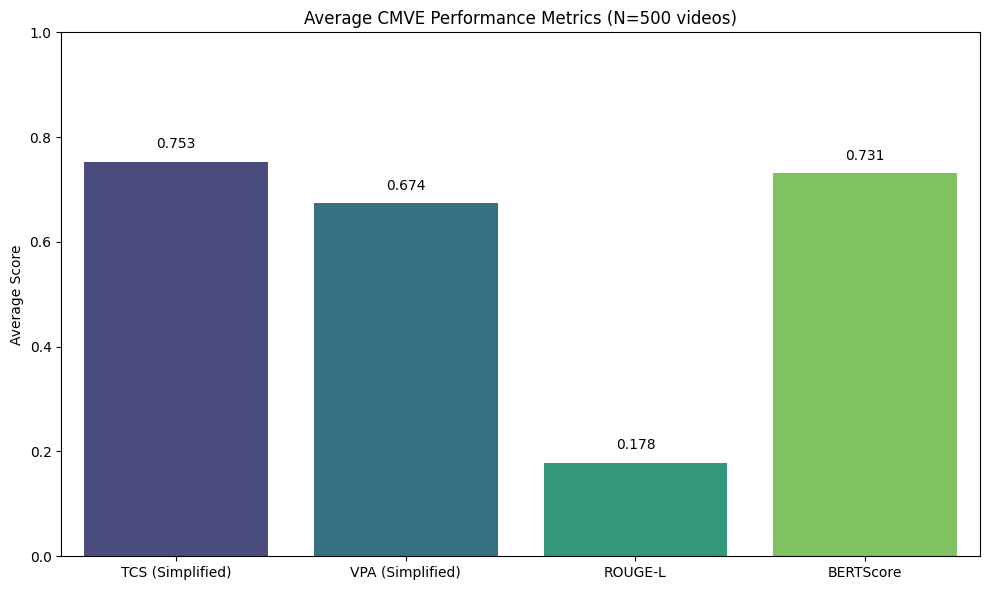


Generating ROUGE-L Score Distribution Histogram...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


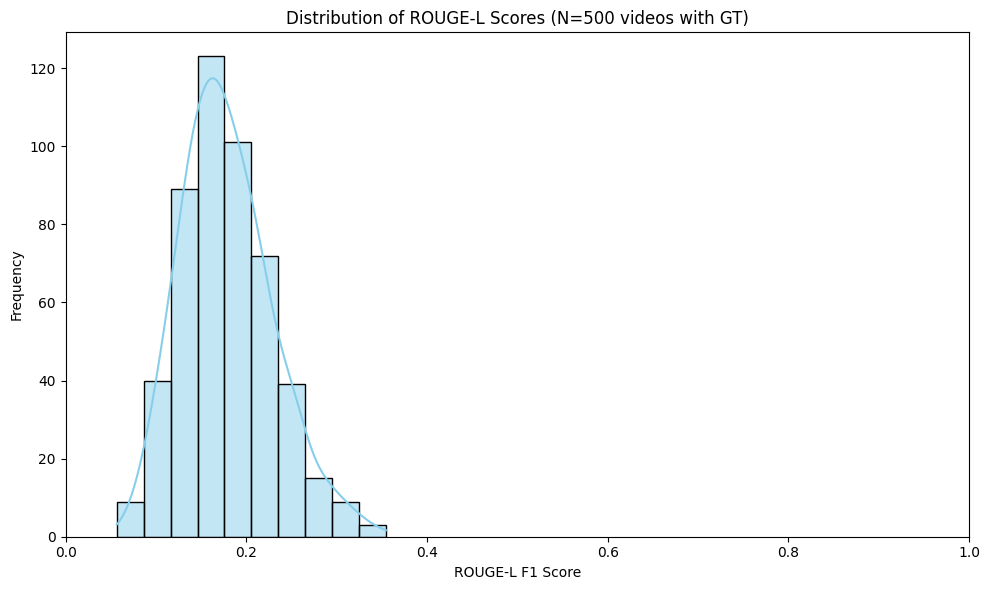


Generating Word Cloud from Explanations...


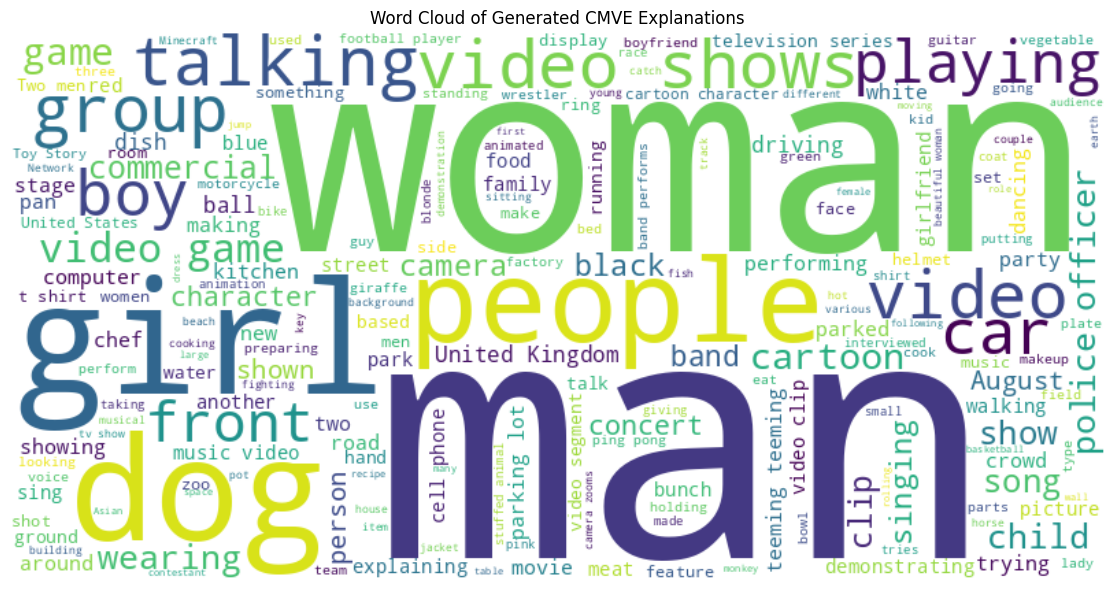


Visualizations generated in 5.30 seconds.


In [ ]:
# %% [code]
# =========================================
# Section 8: Visualizations
# =========================================

print("Generating visualizations...")
viz_start_time = time.time()

# --- Install necessary libraries for plotting ---
!pip install -q matplotlib seaborn wordcloud

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

if 'results' not in globals() or 'metric_scores' not in globals() or 'avg_tcs' not in globals() or 'avg_vpa' not in globals() or 'avg_rougeL' not in globals() or 'avg_bertscore' not in globals() or 'processed_count' not in globals() or 'valid_rouge' not in globals():
    print("Error: Required variables not found. Cannot generate visualizations.")
else:
    # --- Visualization 1: Bar Chart of Average Metric Scores ---
    print("Generating Metric Score Bar Chart...")
    try:
        metric_names = ['TCS (Simplified)', 'VPA (Simplified)', 'ROUGE-L', 'BERTScore']
        avg_scores = [avg_tcs, avg_vpa, avg_rougeL, avg_bertscore]

        plt.figure(figsize=(10, 6))
        if any(score > 0 for score in avg_scores):
            sns.barplot(x=metric_names, y=avg_scores, palette="viridis")
            plt.title(f'Average CMVE Performance Metrics (N={processed_count} videos)')
            plt.ylabel('Average Score')
            plt.ylim(0, 1.0)
            for index, value in enumerate(avg_scores):
                if value is not None:
                    plt.text(index, value + 0.02, f'{value:.3f}', ha='center', va='bottom')
            plt.tight_layout()
            plt.savefig("/kaggle/working/cmve_avg_metrics_bar_chart.png")
            plt.show()
        else:
            print("Skipping Metric Score Bar Chart: All average scores are zero.")

    except Exception as e:
        print(f"Error generating metric score bar chart: {e}")

    # --- Visualization 2: Histogram of ROUGE-L Scores ---
    print("\nGenerating ROUGE-L Score Distribution Histogram...")
    try:
        if valid_rouge and len(valid_rouge) > 1:
            plt.figure(figsize=(10, 6))
            sns.histplot(valid_rouge, bins=10, kde=True, color="skyblue")
            plt.title(f'Distribution of ROUGE-L Scores (N={len(valid_rouge)} videos with GT)')
            plt.xlabel('ROUGE-L F1 Score')
            plt.ylabel('Frequency')
            plt.xlim(0, 1.0)
            plt.tight_layout()
            plt.savefig("/kaggle/working/cmve_rougeL_histogram.png")
            plt.show()
        else:
            print(f"Skipping ROUGE-L histogram: Not enough valid scores available ({len(valid_rouge)}).")
    except Exception as e:
        print(f"Error generating ROUGE-L histogram: {e}")

    # --- Visualization 3: Word Cloud of Generated Explanations ---
    print("\nGenerating Word Cloud from Explanations...")
    try:
        if isinstance(results, dict):
            all_explanations_text = ' '.join([exp for exp in results.values() if isinstance(exp, str) and "Error:" not in exp])
        else:
            all_explanations_text = ""

        if all_explanations_text:
            wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_explanations_text)
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of Generated CMVE Explanations')
            plt.tight_layout()
            plt.savefig("/kaggle/working/cmve_explanations_wordcloud.png")
            plt.show()
        else:
            print("Skipping word cloud: No valid explanations generated.")
    except Exception as e:
        print(f"Error generating word cloud: {e}")

print(f"\nVisualizations generated in {time.time() - viz_start_time:.2f} seconds.")
